In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import gamma
from pynverse import inversefunc as inv
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
import sys
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid", {'axes.grid' : False})
pd.options.display.float_format = '{:,.8f}'.format

In [57]:
# claculate log returns
def calc_logReturns(df_prices):
    df_logReturns = (np.log(df_prices).diff()).fillna(0)
    return df_logReturns

In [58]:
df_data = pd.read_excel('Data (2).xlsx').set_index('Date')
df_data.index = pd.to_datetime(df_data.index)
df_data = df_data[['^CEX','^NYA']] # ^CLLR-^DJUSS
df_data = calc_logReturns(df_data)

stocks = ['^CEX', '^NYA']# ['ADBE', 'MSFT'] 
pairs_selected = ['^CEX-^NYA']# ['ADBE-MSFT']
df_data

,^CEX,^NYA
Date,,
1969-12-31 19:00:41.276,0.00000000,0.00000000
1969-12-31 19:00:41.277,-0.00673955,-0.00280975
1969-12-31 19:00:41.278,0.01173762,0.00693352
1969-12-31 19:00:41.281,-0.00048518,-0.00355623
1969-12-31 19:00:41.282,0.00481456,-0.00377354
...,...,...
1969-12-31 19:00:43.091,0.00382139,-0.00021639
1969-12-31 19:00:43.095,-0.00410738,0.00089509
1969-12-31 19:00:43.096,0.00141326,0.00102141


In [59]:
# df_data = pd.read_csv('GAI_pair.csv').set_index('Date')
# df_data.index = pd.to_datetime(df_data.index)
# df_data.index  =pd.to_datetime([i.strftime('%Y-%m-%d') for i in df_data.index])
# df_data = calc_logReturns(df_data)

# stocks = ['ADBE', 'MSFT'] # ['^DJUSS', '^MID']# ['ADBE', 'MSFT'] 
# pairs_selected = ['ADBE-MSFT'] # ['^DJUSS-^MID']# ['ADBE-MSFT']
# df_data

In [60]:
def train_test_split(df_data:pd.DataFrame,train_start:datetime.datetime,train_end:datetime.datetime, test_start:datetime.datetime, test_end:datetime.datetime)->pd.DataFrame:
    '''
    Helper function to split the train and test data
    para:
    - df_data: pd.DataFrame, data to be split
    - train_start: datetime.datetime, train start date
    - train_end: datetime.datetime, train end date
    - test_start: datetime.datetime, test start date
    - test_end: datetime.datetime, test end date
    return:
    - df_train: pd.DataFrame, train data
    - df_test: pd.DataFrame, test data
    '''
    df_train = df_data[train_start:train_end]
    df_test = df_data[test_start:test_end]
    return df_train, df_test

In [61]:
form_start = datetime.datetime(2019, 1, 1)
form_end = datetime.datetime(2022, 1, 1)
trade_start = datetime.datetime(2022, 1, 1)
trade_end = datetime.datetime(2023, 1, 1)

# df_data_form, df_data_trade = train_test_split(
#     df_data, form_start, form_end, trade_start, trade_end)
df_data_form, df_data_trade = df_data[:int(0.7*len(df_data))], df_data[int(0.7*len(df_data)):]

In [62]:
# parse pairs
def parse_pair(pair: str) -> str:
    '''
    Helper function to parse the pairs' name(str)
    para:
    - pair: str, a pair in the form of 'A-B'
    return:
    - stock_1, stock_2: two stock components of the pair
    '''
    stock_1 = pair[:pair.find('-')]
    stock_2 = pair[pair.find('-')+1:]
    return stock_1, stock_2

# calculate kendalls tau
def calc_tau(stocks: list, df_data: pd.DataFrame) -> pd.DataFrame:
    '''
    Calculate tau of all the pairs formed by given stocks
    para:
    - stocks: list, list of stocks
    - df_data: pd.Dataframe, time series data to be used for pair trading
    return:
    - df_tau_results: pd.DataFrame, tau values in ascending order
    '''
    df_tau_results = pd.DataFrame(columns=['tau'])
    l = len(stocks)
    for i in range(l-1):
        for j in range(i+1, l):
            if (stocks[i] != stocks[j]) and (f'{stocks[i]}-{stocks[j]}' not in df_tau_results.index):
                df_tau_results.loc[f'{stocks[i]}-{stocks[j]}'] = stats.kendalltau(
                    df_data[stocks[i]], df_data[stocks[j]])[0]
    df_tau_results.sort_values(by='tau', inplace=True)

    return df_tau_results

## Functions for fitting Copula family and parameters

In [63]:
from copulae.archimedean import GumbelCopula, FrankCopula, ClaytonCopula
from copulae.elliptical import GaussianCopula, StudentCopula
from scipy.stats import norm
from scipy.stats import t


def fit_copula(df_data: pd.DataFrame, pairs_selected: list) -> pd.DataFrame:
    '''
    Find the best fitted Copula family and corresponding parameters
    para:
    - df_data: pd.DataFrame, fitted data
    - pairs-selected: list, list of selected pairs
    return:
    - df_copula_results, pd.DataFrame, conclusion of fitted results
    '''
    df_copula_results = pd.DataFrame(index=pairs_selected, columns=[
                                     'copula', 'parameter', 'aic', 'bic'])

    for pair in pairs_selected:
        s1, s2 = parse_pair(pair)
        print(df_data[s1], df_data[s2])
        u, v = ECDF(df_data[s1])(df_data[s1]), ECDF(df_data[s2])(df_data[s2])
        print(u, v)
        data_selected = pd.DataFrame(data={s1: u, s2: v}, columns=[s1, s2])
        _, ndim = data_selected.shape

        best_aic = np.inf

        for copula in [GumbelCopula(dim=ndim), FrankCopula(dim=ndim), ClaytonCopula(dim=ndim), GaussianCopula(dim=ndim), StudentCopula(dim=ndim)]:
            copula.fit(data_selected)
            L = copula.log_lik(data_selected)
            param = copula.params
            num_params = 1
            if isinstance(param, np.ndarray):
                num_params = len(param)
            aic = 2 * num_params - 2 * L
            if aic < best_aic:
                best_aic = aic
                best_bic = num_params * np.log(len(u)) - 2 * L
                best_copula = copula.name

                if isinstance(copula, StudentCopula):
                    best_param = [copula.params[0], copula.params[1][0]]
                else:
                    best_param = copula.params

        df_copula_results.loc[pair] = [
            best_copula, best_param, best_aic, best_bic]
    return df_copula_results


def copula_params(df_data_reform: pd.DataFrame, df_tau_results: pd.DataFrame, pair: str, family: str) -> float:
    '''
    Calculate the parameter Theta of specific copula functions
    para:
    - df_data_reform: pd.DataFrame, data used to re-estimate copula and parameters
    - df_tau_results: pd.DataFrame, tau results of pairs
    - pair: str, specific pair
    - family: str, name of copula function
    return:
    - copula's parameter(s)
    '''
    tau = df_tau_results['tau'][pair]
    rho = np.sin(np.pi/2*tau)

    if family == 'Clayton':
        return 2*tau/float(1-tau)
    elif family == 'Frank':
        def integrand(t): return t/(np.exp(t)-1)
        def frank_fun(theta): return ((tau - 1)/4.0 - (quad(integrand,
                                                            sys.float_info.epsilon, theta)[0]/theta - 1)/theta)**2
        return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x[0]
    elif family == 'Gumbel':
        return 1/(1-tau)
    elif family == 'Gaussian':
        return rho
    elif family == 'Student':
        s1, s2 = parse_pair(pair)
        u, v = ECDF(df_data_reform[s1])(df_data_reform[s1]), ECDF(
            df_data_reform[s2])(df_data_reform[s2])
        data_selected = pd.DataFrame(data={s1: u, s2: v}, columns=[s1, s2])
        copula = StudentCopula(dim=2)
        copula.fit(data_selected)
        L = copula.log_lik(data_selected)
        if isinstance(copula, StudentCopula):
            return [copula.params[0], copula.params[1][0]]


def calc_MPI(family: str, theta: float, U: np.array, V: np.array) -> float:
    '''
    Calculate Mispricing Index, which is the conditional cdf of Copula functions
    para:
    - family: str, copula family name
    - theta: float, parameter of copula function
    - U: np.array, quantile value of stock 1
    - V: np.array, quantile value of stock 2
    return:
    - MPI_u_v: float, conditional cdf of u given v
    - MPI_v_u: float, conditional cdf of v given u
    '''
    if family == 'Clayton':
        A_v = np.power(V, -theta - 1)
        A_u = np.power(U, -theta - 1)
        if (A_v == np.inf).any():
            MPI_u_v = np.zeros(len(V))
        if (A_u == np.inf).any():
            MPI_v_u = np.zeros(len(U))

        B = np.power(V, -theta) + np.power(U, -theta) - 1
        h = np.power(B, (-1 - theta) / theta)
        MPI_u_v = A_v * h
        MPI_v_u = A_u*h

    elif family == 'Frank':
        if theta == 0:
            return V
        else:
            A = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta * V) - 1)
            B = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta * U) - 1)
            C = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta) - 1)
            if C == 0.0:
                return 0.5, 0.5
            MPI_u_v = B / C
            MPI_v_u = A / C

    elif family == 'Gumbel':
        if theta == 1:
            return V
        else:
            t1 = np.power(-np.log(U), theta)
            t2 = np.power(-np.log(V), theta)
            p1 = U * V if theta == 1 else np.exp(-np.power(
                np.power(-np.log(U), theta) + np.power(-np.log(V), theta), 1.0 / theta))
            p2 = np.power(t1 + t2, -1 + 1.0 / theta)
            MPI_u_v = p1 * p2 * np.power(-np.log(V), theta - 1) / V
            MPI_v_u = p1 * p2 * np.power(-np.log(U), theta - 1) / U

    elif family == 'Gaussian':
        MPI_u_v = norm.cdf(norm.ppf(U)-theta*norm.ppf(V) / np.sqrt(1-theta**2))
        MPI_v_u = norm.cdf(norm.ppf(V)-theta*norm.ppf(U) / np.sqrt(1-theta**2))

    elif family == 'Student':
        n = theta[0]  # corr
        rho = theta[1]  # df
        MPI_u_v = t.cdf(np.sqrt((n+1) / (n+t.ppf(V, n)**2)) *
                        (t.ppf(U, n)-rho*t.ppf(V, n)) / np.sqrt(1-rho**2), n+1)
        MPI_v_u = t.cdf(np.sqrt((n+1) / (n+t.ppf(U, n)**2)) *
                        (t.ppf(V, n)-rho*t.ppf(U, n)) / np.sqrt(1-rho**2), n+1)
        if MPI_u_v is np.NaN or MPI_v_u is np.NaN:
            print('Error')

    return MPI_u_v, MPI_v_u


 ## Functions for copula-based pair trading formation, re-estimation and trading implementation

In [64]:
def train_test_split(df_data:pd.DataFrame,train_start:datetime.datetime,train_end:datetime.datetime, test_start:datetime.datetime, test_end:datetime.datetime)->pd.DataFrame:
    '''
    Helper function to split the train and test data
    para:
    - df_data: pd.DataFrame, data to be split
    - train_start: datetime.datetime, train start date
    - train_end: datetime.datetime, train end date
    - test_start: datetime.datetime, test start date
    - test_end: datetime.datetime, test end date
    return:
    - df_train: pd.DataFrame, train data
    - df_test: pd.DataFrame, test data
    '''
    df_train = df_data[train_start:train_end]
    df_test = df_data[test_start:test_end]
    return df_train, df_test 


def copula_formation(df_data_form:pd.DataFrame, df_tau_results:pd.DataFrame, pairs_selected:list):
    '''
    Form the copula results
    para:
    - df_data_form: pd.DataFrame, data used to form copula results
    - df_tau_results, pd.DataFrame, calculated tau results of all pairs
    - paris_selected: list, selected pairs
    return:
    - df_copula_results: pd.DataFrame, fitted copula results
    '''
    df_copula_results = fit_copula(df_data_form, pairs_selected)
    df_copula_results = pd.concat([df_copula_results, df_tau_results], axis=1)
    return df_copula_results


def copula_update(df_data_reform:pd.DataFrame, df_copula_results:pd.DataFrame, pair:str):
    '''
    Re-estimate the copula results, especially the parameters
    para:
    - df_data_reform: pd.DataFrame, data used to re-form copula results
    - df_copula_results, pd.DataFrame, preious fitted copula results
    - pair: str, selected pair
    return:
    - df_copula_results: pd.DataFrame, new fitted copula results
    '''
    stocks = list(parse_pair(pair))
    df_tau_results = calc_tau(stocks, df_data_reform)
    family = df_copula_results['copula'][pair]
    theta = copula_params(df_data_reform, df_tau_results, pair, family)
    df_copula_results['parameter'][pair] = theta
    df_copula_results['tau'][pair] = df_tau_results['tau'][pair]

    return df_copula_results


def copula_trading(df_data_form:pd.DataFrame, df_data_trade:pd.DataFrame, df_copula_results:pd.DataFrame, pair:str, threshold:float):
    '''
    Implement trading strategy
    para:
    - df_data_form: pd.DataFrame, data used to form copula
    - df_data_trade: pd.DataFrame, data used to trade
    - df_copula_results: pd.DataFrame, fitted copula results
    - pair: str, selected pair
    - threshold: float, threshod of trading index
    '''
    global df_data
    
    stock_1, stock_2 = parse_pair(pair)
    data_form = df_data_form.loc[:,[stock_1, stock_2]]
    data_trade = df_data_trade.loc[:,[stock_1, stock_2]]
    quantiles_u = ECDF(data_form[stock_1].append(pd.Series([-10**6,10**6])))
    quantiles_v = ECDF(data_form[stock_2].append(pd.Series([-10**6,10**6])))
    family = df_copula_results['copula'][pair]
    theta = df_copula_results['parameter'][pair]
    df_copula_results_cp = df_copula_results.copy()

    quantiles_res = {'Quantile_1':[],'Quantile_2':[]}
    MPI_res = {'MPI_1':[],'MPI_2':[]}
    CMPI_res = {'CMPI_1':[],'CMPI_2':[]}
    df_positions = pd.DataFrame(index=data_trade.index, columns=[
                                    stock_1, stock_2, 'Signal', 'Open/Close'])
    
    long = False
    short = False
    trade_start = df_data_trade.index[0]

    for t in data_trade.index:
        if t == trade_start + relativedelta(months=1):
            df_data_reform = df_data[t-relativedelta(years=3):t]
            df_copula_results_cp = copula_update(df_data_reform, df_copula_results_cp, pair)
            theta = df_copula_results_cp.loc[pair, 'parameter']
            trade_start = t
        # 1. Calculate quantiles of test data according to train data
        u = data_trade.loc[t,stock_1]
        v = data_trade.loc[t,stock_2]
        u_q = quantiles_u(u)
        v_q = quantiles_v(v)

        # 2. Calculate MPI
        MPI_u_v, MPI_v_u = calc_MPI(family, theta, u_q, v_q)
        MPI_u_v -= 0.5
        MPI_v_u -= 0.5

        # 3. Calculate CMPI
        if t == data_trade.index[0]:
            CMPI_u_v = MPI_u_v
            CMPI_v_u = MPI_v_u
        else:
            CMPI_u_v = MPI_u_v + CMPI_res['CMPI_1'][-1]
            CMPI_v_u = MPI_v_u + CMPI_res['CMPI_2'][-1]
            if abs(CMPI_u_v) >= 1.9 or abs(CMPI_v_u) >= 1.9:
                CMPI_u_v = 0.0
                CMPI_v_u = 0.0

        quantiles_res['Quantile_1'].append(u_q)
        quantiles_res['Quantile_2'].append(v_q)
        MPI_res['MPI_1'].append(MPI_u_v)
        MPI_res['MPI_2'].append(MPI_v_u)
        CMPI_res['CMPI_1'].append(CMPI_u_v)
        CMPI_res['CMPI_2'].append(CMPI_v_u)


        # 4. Check trading signals
        if t == df_data_trade.index[-1]:
            df_positions.loc[t] = [0, 0, 'Close', 'Close']
            break
        # if long position is open
        if long:
            if (CMPI_u_v >= 0) or (CMPI_v_u <= 0):
                df_positions.loc[t] = [0, 0, 'Close', 'Close']
                long = False
            else:
                df_positions.loc[t] = [1, -1, 'Hold', 'Open']
        # if short position is open
        elif short:
            if (CMPI_u_v <= 0) or (CMPI_v_u >= 0):
                df_positions.loc[t] = [0, 0, 'Close', 'Close']
                short = False
            else:
                df_positions.loc[t] = [-1, 1, 'Hold', 'Open']
        # if no positions are open
        else:
            # Long asset1 is undervalued(CMPI<-0.6 / MPI<-0.45) and short asset2 is overvalued(CMPI>0.6 / MPI>0.45)
            if (CMPI_u_v < -threshold) or (CMPI_v_u > threshold):
                # long asset1 and short asset2
                df_positions.loc[t] = [1, -1, 'Buy', 'Open']
                long = True
            # short asset1 is overvalued(CMPI>0.6 / MPI>0.45)) and long asset2 is undervalued(CMPI<-0.6 / MPI<-0.45)
            elif (CMPI_u_v > threshold) or (CMPI_v_u < -threshold):
                # short asset1 and long asset2
                df_positions.loc[t] = [-1, 1, 'Sell', 'Open']
                short = True
            else:
                df_positions.loc[t] = [0, 0, 'Hold', 'Close']

    calculations_res = {**quantiles_res, **MPI_res, **CMPI_res}
    df_calculations = pd.DataFrame(calculations_res, index=data_trade.index)
    df_calculations.columns = ['Quantile_'+stock_1, 'Quantile_'+stock_2, 'MPI_'+stock_1, 'MPI_'+stock_2, 'CMPI_'+stock_1, 'CMPI_'+stock_2]

    df_returns = df_positions[[stock_1, stock_2]].shift() * (np.exp(data_trade)-1)
    df_returns.columns = ['Return_'+stock_1, 'Return_'+stock_2]

    df_positions.columns = ['Position_'+stock_1, 'Position_'+stock_2, 'Signal', 'Open/Close']
    print('Positions table:\n', df_positions.loc[df_positions['Signal']!='Hold',:])

    return df_calculations, df_positions, df_returns.dropna()
        

## Functions for measuring performance

In [65]:
def metrics(df_return):
    '''
    Measure trading performance
    para:
    - df_return: pd.DataFrame, trading returns of a pair
    return:
    - df_performance_metrics: pd.DataFrame, performance metrics 
    '''
    # 1. Total cumulative return
    cum_return_df = pd.Series(np.cumprod(df_return+1))
    total_cum_return = cum_return_df[-1]-1

    # 2. Winning rate
    winning_rate = len(df_return[df_return > 0])/len(df_return)

    # 3. Maximum number of consecutive losses
    counter = 0
    max_score = 0
    for p in df_return:
        if p < 0:
            counter += 1
        else:
            if counter > 0:
                max_score = max(max_score, counter)
            counter = 0
    max_score = max(max_score, counter)

    # 4. Max drawdown
    max_drawdown = np.max(
        1 - cum_return_df/np.maximum.accumulate(cum_return_df))

    # 5. Sharpe Ratio
    sharpe_ratio = np.mean(df_return)/np.std(df_return) * \
        np.sqrt(252) if np.std(df_return) != 0.0 else 0.0

    # 6. Sortino Ratio
    mean = np.mean(df_return)
    cum = 0
    for item in df_return:
        if item < mean:
            cum = cum + (item - mean) ** 2
    downdev = np.sqrt(cum/len(df_return))
    sortino_ratio = np.mean(df_return) / downdev

    metrics_res = {'Cumulative Return': [total_cum_return], 'Sharpe Ratio': [sharpe_ratio], 'Max Drawdown': [max_drawdown],
                   'Maxnum Consecutive Losses': [max_score], 'Winning Rate': [winning_rate],
                   'Sortino Ratio': [sortino_ratio]}
    df_performance_metrics = pd.DataFrame(data=metrics_res, index=['Metrics'])

    return df_performance_metrics

## Fit copula

In [66]:
df_tau_results = calc_tau(stocks, df_data_form)
df_tau_results

,tau
^CEX-^NYA,0.64259788


In [67]:
df_data_form

,^CEX,^NYA
Date,,
1969-12-31 19:00:41.276,0.00000000,0.00000000
1969-12-31 19:00:41.277,-0.00673955,-0.00280975
1969-12-31 19:00:41.278,0.01173762,0.00693352
1969-12-31 19:00:41.281,-0.00048518,-0.00355623
1969-12-31 19:00:41.282,0.00481456,-0.00377354
...,...,...
1969-12-31 19:00:42.545,-0.04728998,-0.04396071
1969-12-31 19:00:42.548,-0.03469668,-0.02083413
1969-12-31 19:00:42.549,0.00297034,0.01863703


In [68]:
df_copula_results = copula_formation(
    df_data_form, df_tau_results.loc[pairs_selected], pairs_selected)

df_copula_results.to_excel('Copula_Result.xlsx')
df_copula_results


Date
1969-12-31 19:00:41.276    0.00000000
1969-12-31 19:00:41.277   -0.00673955
1969-12-31 19:00:41.278    0.01173762
1969-12-31 19:00:41.281   -0.00048518
1969-12-31 19:00:41.282    0.00481456
                              ...    
1969-12-31 19:00:42.545   -0.04728998
1969-12-31 19:00:42.548   -0.03469668
1969-12-31 19:00:42.549    0.00297034
1969-12-31 19:00:42.550    0.01806408
1969-12-31 19:00:42.551    0.01082691
Name: ^CEX, Length: 881, dtype: float64 Date
1969-12-31 19:00:41.276    0.00000000
1969-12-31 19:00:41.277   -0.00280975
1969-12-31 19:00:41.278    0.00693352
1969-12-31 19:00:41.281   -0.00355623
1969-12-31 19:00:41.282   -0.00377354
                              ...    
1969-12-31 19:00:42.545   -0.04396071
1969-12-31 19:00:42.548   -0.02083413
1969-12-31 19:00:42.549    0.01863703
1969-12-31 19:00:42.550    0.01846513
1969-12-31 19:00:42.551    0.01336177
Name: ^NYA, Length: 881, dtype: float64
[0.45516459 0.21906924 0.88989784 0.43359818 0.67309875 0.82406356
 0.6095

,copula,parameter,aic,bic,tau
^CEX-^NYA,Student,"[3.792750189275346, 0.8482388490562359]","-1,154.28294780","-1,149.50189017",0.64259788


## Implement trading strategy to all selected pairs & Visualize the trading outcome

Positions table:
                         Position_^CEX Position_^NYA Signal Open/Close
Date                                                                 
1969-12-31 19:00:42.556             1            -1    Buy       Open
1969-12-31 19:00:42.564             0             0  Close      Close
1969-12-31 19:00:42.566            -1             1   Sell       Open
1969-12-31 19:00:42.591             0             0  Close      Close
1969-12-31 19:00:42.601            -1             1   Sell       Open
...                               ...           ...    ...        ...
1969-12-31 19:00:43.069             0             0  Close      Close
1969-12-31 19:00:43.070             1            -1    Buy       Open
1969-12-31 19:00:43.074             0             0  Close      Close
1969-12-31 19:00:43.077             1            -1    Buy       Open
1969-12-31 19:00:43.098             0             0  Close      Close

[76 rows x 4 columns]


{'^CEX-^NYA': {'calculations':                          Quantile_^CEX  Quantile_^NYA    MPI_^CEX    MPI_^NYA  \
  Date                                                                            
  1969-12-31 19:00:42.552     0.37372593     0.60702152 -0.36488439  0.36096905   
  1969-12-31 19:00:42.556     0.05775764     0.09739524 -0.34907900  0.08420685   
  1969-12-31 19:00:42.557     0.34881087     0.64212911 -0.40960257  0.40812956   
  1969-12-31 19:00:42.558     0.65118913     0.32049830  0.42782193 -0.43178998   
  1969-12-31 19:00:42.559     0.98754247     0.96149490  0.45238496 -0.22692870   
  ...                                ...            ...         ...         ...   
  1969-12-31 19:00:43.091     0.62967157     0.45186863  0.31446373 -0.29460619   
  1969-12-31 19:00:43.095     0.30124575     0.52095130 -0.37436411  0.33720263   
  1969-12-31 19:00:43.096     0.52774632     0.52887882  0.00698875  0.01150333   
  1969-12-31 19:00:43.097     0.61155153     0.60249151  0

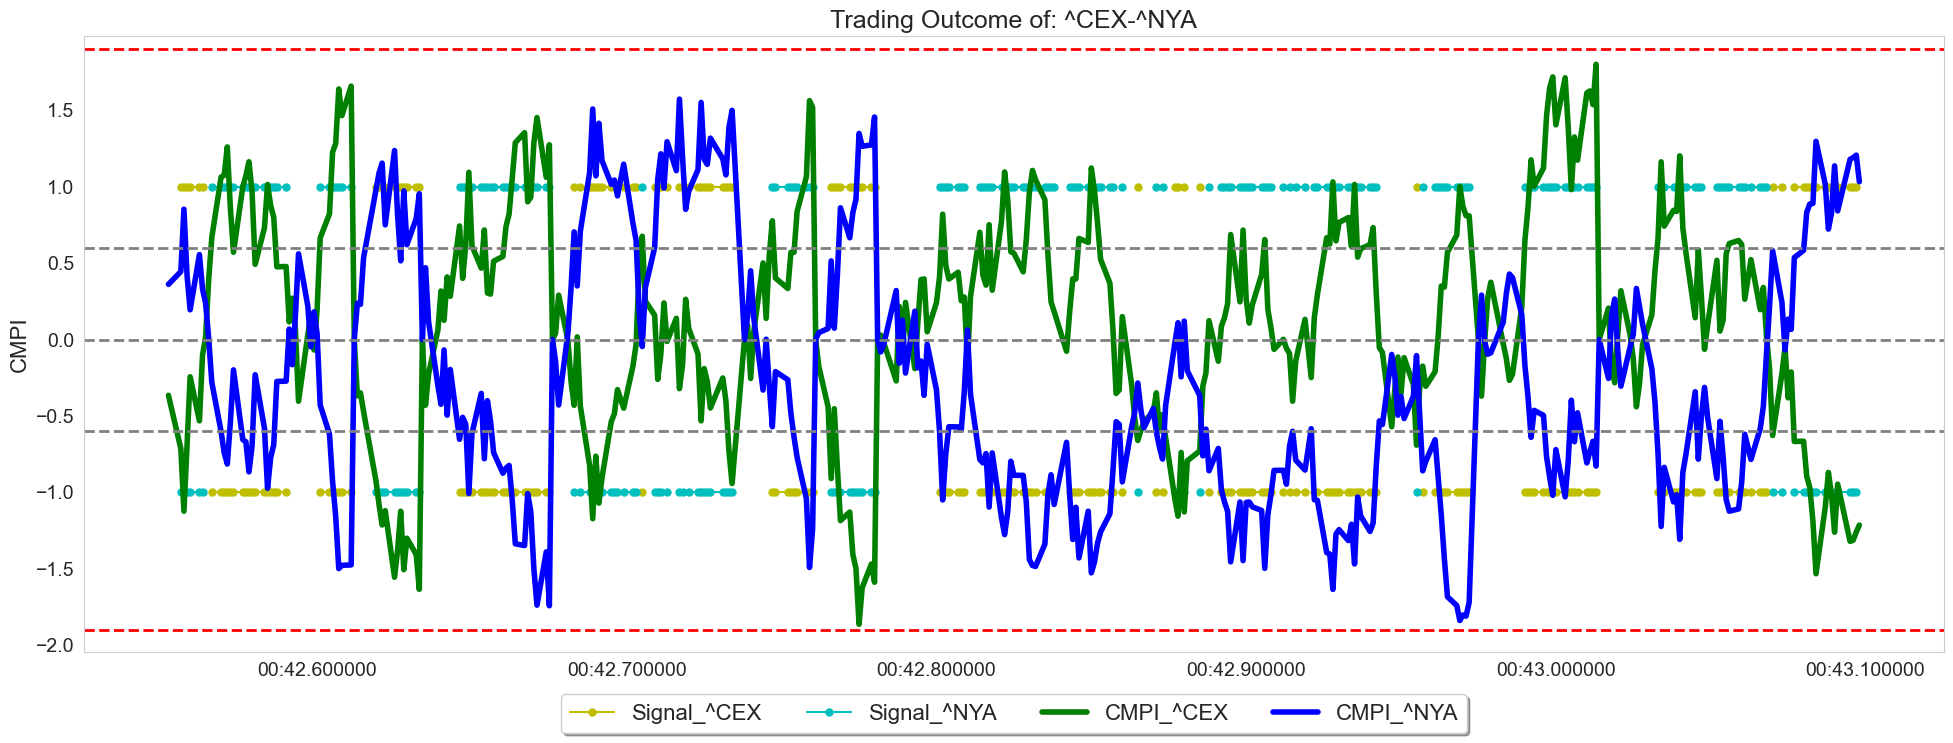

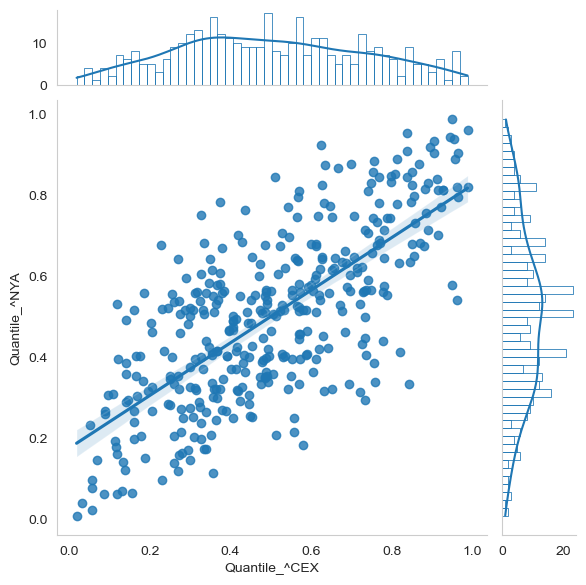

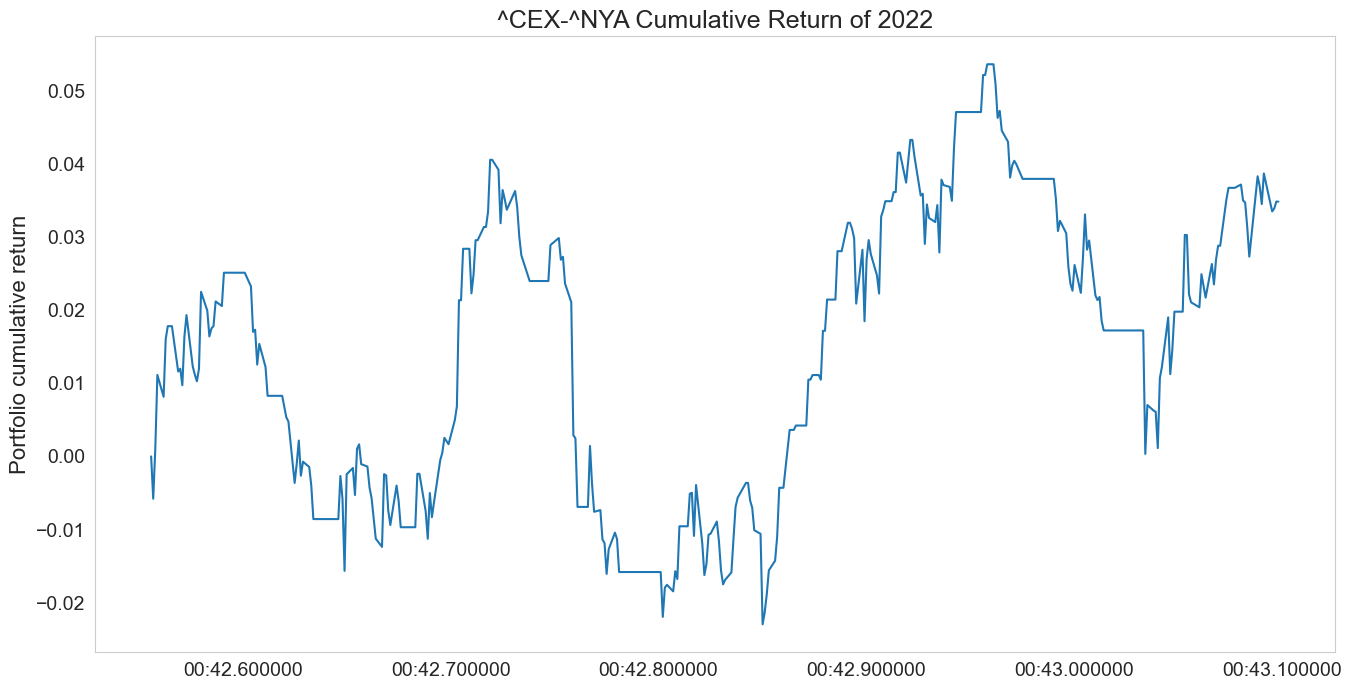

In [69]:
threshold = 0.6
trade_results = {}
df_pairs_metrics = pd.DataFrame(index=pairs_selected, columns=[
    'Cumulative Return', 'Sharpe Ratio', 'Max Drawdown', 'Maxnum Consecutive Losses',  'Winning Rate', 'Sortino Ratio'])

for pair in pairs_selected:
    stock_1, stock_2 = parse_pair(pair)
    df_calculations, df_positions, df_returns = copula_trading(
        df_data_form, df_data_trade, df_copula_results, pair, threshold)

    trade_results[pair] = {'calculations': df_calculations,
                           'positions': df_positions,
                           'returns': df_returns,
                           'metrics': metrics(df_returns.sum(axis=1))}
    df_pairs_metrics.loc[pair] = trade_results[pair]['metrics'].values[0].tolist()

    plt.figure(figsize=(24, 8))
    plt.grid(False)
    plt.title('Trading Outcome of: '+pair, fontsize=18)

    colors = ['y', 'c', 'g', 'b']
    for column, color in zip(trade_results[pair]['positions'].columns[:2], colors[:2]):
        plt.plot(trade_results[pair]['positions'][column].replace(
            0, np.nan), color=color, marker=".", markersize=10)
    for column, color in zip(trade_results[pair]['calculations'].columns[-2:], colors[2:]):
        plt.plot(trade_results[pair]['calculations']
                 [column], color=color, linewidth='4')
    plt.axhline(0.0, color='gray', linestyle='dashed', linewidth='2')
    plt.axhline(0.6, color='gray', linestyle='dashed', linewidth='2')
    plt.axhline(-0.6, color='gray', linestyle='dashed', linewidth='2')
    plt.axhline(1.9, color='r', linestyle='dashed', linewidth='2')
    plt.axhline(-1.9, color='r', linestyle='dashed', linewidth='2')
    plt.legend(['Signal_'+stock_1, 'Signal_' +
               stock_2, 'CMPI_'+stock_1, 'CMPI_'+stock_2], loc='upper center', fontsize='16', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=4)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('CMPI', fontsize=16)

    sns.jointplot(data=df_calculations.iloc[:, :2], x="Quantile_"+stock_1, y="Quantile_" +
                  stock_2, kind="reg", marginal_ticks=True, marginal_kws=dict(bins=50, fill=False))
    
    plt.figure(figsize=(16, 8))
    plt.grid(False)
    plt.plot(np.cumprod(df_returns.sum(axis=1)+1)-1)
    plt.title(pair+' Cumulative Return of 2022', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Portfolio cumulative return', fontsize=16)

trade_results
